In [41]:
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle
from pylab import cm
from matplotlib.colors import hsv_to_rgb
%matplotlib inline

[]

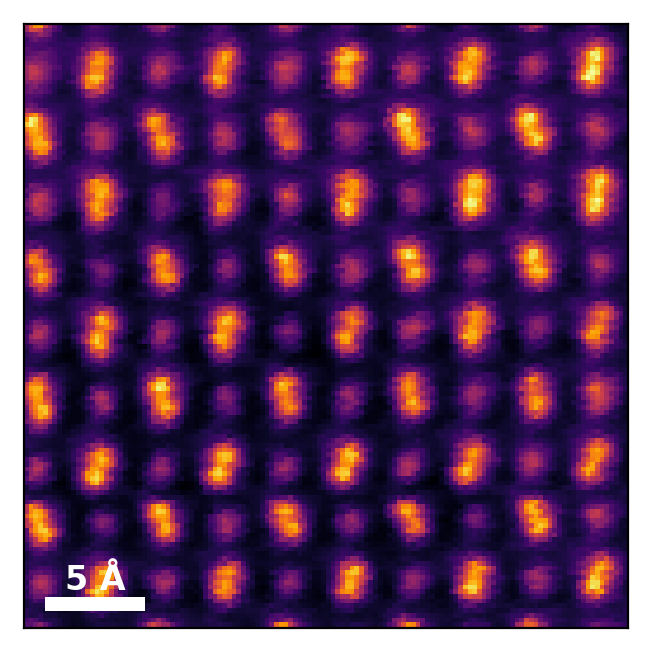

In [2]:
fname='/Users/j6h/Documents/Nion/Swift/PlugIns/GetDPC/GetDPCDemoData_4D.npy'
dat4d=np.load(fname)
datim=np.load(fname[:-6]+'ADF.npy')
md=json.load(open(fname[:-6]+'ADF.json','r')) 
### Note this is an old dataset this command doesn't work on latest version of Swift
### I can't use my newest datasets because we're still trying to publish the results
FOV=md['metadata']['hardware_source']['autostem']['fov_nm']

### For my newer datasets on more recent versions of Swift I use 4D dataset .json and 
### the following command
### FOV=md['metadata']['scan_detector']['autostem']['fov_nm']

imcal=FOV/np.amax(dat4d.shape[:2])
f,a=plt.subplots(1,1,dpi=200)
a.imshow(datim,cmap=cm.inferno)
a.add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a.text(4+0.25/imcal,dat4d.shape[0]-7,'5 Å',fontweight='bold',color='w',fontsize=12,ha='center',va='bottom')
plt.setp(a, xticks=[],yticks=[])

[]

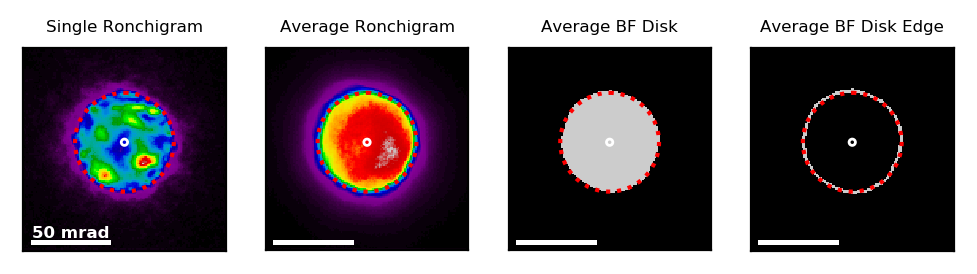

In [3]:
def CalibrateRonchigram(dat4d,conv=32.,t=0.3):
    ### Find true center of Ronchigram, and pixels/mrad calibration
    ### Needed Inputs: dat4d - 4D Dataset, 2-spatial, 2-diffraction dimensions
    ###                conv - Convergence Angle of Electron Probe in mrad 
    ###                t - Threshhold for BF Disk (fraction of 1)
    
    R=np.average(dat4d,axis=(0,1))
    Rn=(R-np.amin(R))/np.ptp(R)
    BFdisk=np.ones(R.shape)*(Rn>t)
    rxx,ryy = np.meshgrid(np.arange(0,Rn.shape[1]), np.arange(0,Rn.shape[0]))
    rcx,rcy=np.sum(BFdisk*rxx/np.sum(BFdisk)),np.sum(BFdisk*ryy/np.sum(BFdisk))
    edge=(np.sum(np.abs(np.gradient(BFdisk)),axis=0))>t
    pixcal=np.average(np.sqrt((rxx-rcx)**2+(ryy-rcy)**2)[edge])/conv
    return rcx,rcy,pixcal,BFdisk,edge

ConvergenceAngle=32.
cals4d=CalibrateRonchigram(dat4d,conv=ConvergenceAngle,t=0.3)
RonchiCenterX,RonchiCenterY,Ronchipixcal,BFdiskIm,BFEdgeIm=cals4d

f,a=plt.subplots(1,4,dpi=200)
a[0].imshow(dat4d[0,0],cmap=cm.nipy_spectral)
a[0].add_patch(Circle((RonchiCenterX,RonchiCenterY),radius=ConvergenceAngle*Ronchipixcal,
                    ec='r',fc='None',lw=1.5,ls=':'))
a[0].add_patch(Circle((RonchiCenterX,RonchiCenterY),radius=2,ec='w',fc='None',lw=1.))
a[0].set_title('Single Ronchigram',fontsize=6)
a[0].add_patch(Rectangle((4,dat4d.shape[2]-7),50/Ronchipixcal,3,fc='w',ec='None'))
a[0].text(4+25/Ronchipixcal,dat4d.shape[2]-7,'50 mrad',fontweight='bold',color='w',fontsize=6,ha='center',va='bottom')
a[1].imshow(np.average(dat4d,axis=(0,1)),cmap=cm.nipy_spectral)
a[1].add_patch(Circle((RonchiCenterX,RonchiCenterY),radius=ConvergenceAngle*Ronchipixcal,
                    ec='r',fc='None',lw=1.5,ls=':'))
a[1].add_patch(Circle((RonchiCenterX,RonchiCenterY),radius=2,ec='w',fc='None',lw=1.))
a[1].set_title('Average Ronchigram',fontsize=6)
a[1].add_patch(Rectangle((4,dat4d.shape[2]-7),50/Ronchipixcal,3,fc='w',ec='None'))
a[2].imshow(BFdiskIm,cmap=cm.nipy_spectral)
a[2].add_patch(Circle((RonchiCenterX,RonchiCenterY),radius=ConvergenceAngle*Ronchipixcal,
                    ec='r',fc='None',lw=1.5,ls=':'))
a[2].add_patch(Circle((RonchiCenterX,RonchiCenterY),radius=2,ec='w',fc='None',lw=1.))
a[2].set_title('Average BF Disk',fontsize=6)
a[2].add_patch(Rectangle((4,dat4d.shape[2]-7),50/Ronchipixcal,3,fc='w',ec='None'))
a[3].imshow(BFEdgeIm,cmap=cm.nipy_spectral)
a[3].add_patch(Circle((RonchiCenterX,RonchiCenterY),radius=ConvergenceAngle*Ronchipixcal,
                    ec='r',fc='None',lw=1.5,ls=':'))
a[3].add_patch(Circle((RonchiCenterX,RonchiCenterY),radius=2,ec='w',fc='None',lw=1.))
a[3].set_title('Average BF Disk Edge',fontsize=6)
a[3].add_patch(Rectangle((4,dat4d.shape[2]-7),50/Ronchipixcal,3,fc='w',ec='None'))
plt.setp(a, xticks=[],yticks=[])

[]

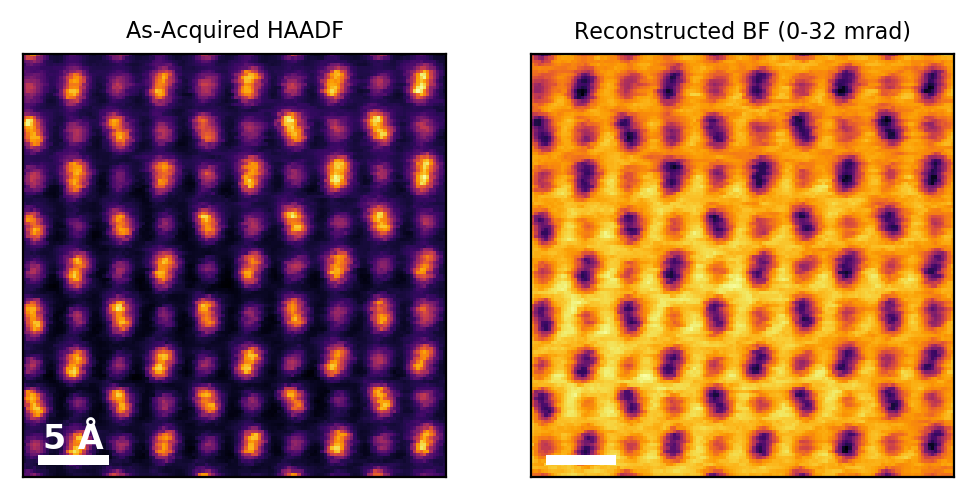

In [4]:
def GetDetectorImage(dat4d,RCX,RCY,RCal,RI,RO):
    ### Reconstruct a detector image from the 4D Dataset
    ### Needed Inputs: dat4d - 4D Dataset, 2-spatial, 2-diffraction dimensions
    ###                RCX,RCY - Center of the Ronchigram (pixels)
    ###                RCal - Calibration of the Ronchigram (pixels/mrad)
    ###                RI - Inner Detector Radius (mrad)
    ###                RO - Outer Detector Radius (mrad)
    X,Y = np.meshgrid((np.arange(0,dat4d.shape[3])-RCX)/RCal, (np.arange(0,dat4d.shape[2])-RCY)/RCal)
    return np.average(dat4d*((X**2+Y**2>=RI**2) & (X**2+Y**2<RO**2)),axis=(2,3))
BF=GetDetectorImage(dat4d,RonchiCenterX,RonchiCenterY,Ronchipixcal,0.,ConvergenceAngle)
f,a=plt.subplots(1,2,dpi=200)
a[0].imshow(datim,cmap=cm.inferno)
a[0].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[0].text(4+0.25/imcal,dat4d.shape[0]-7,'5 Å',fontweight='bold',color='w',fontsize=12,ha='center',va='bottom')
a[0].set_title('As-Acquired HAADF',fontsize=8)
a[1].imshow(BF,cmap=cm.inferno)
a[1].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[1].set_title('Reconstructed BF (0-32 mrad)',fontsize=8)
plt.setp(a, xticks=[],yticks=[])

[]

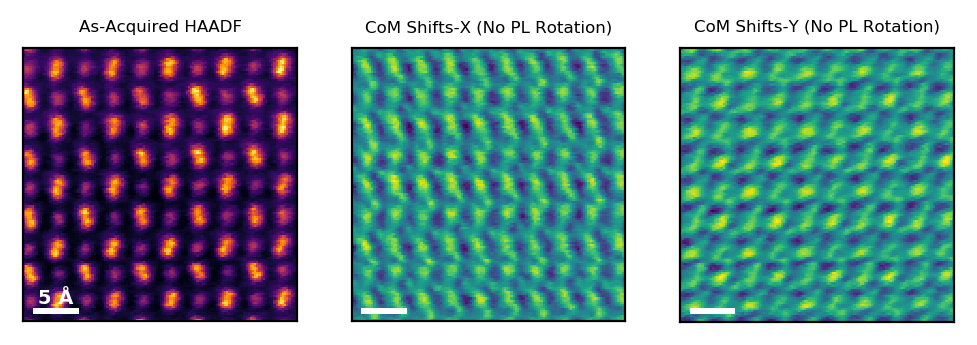

In [10]:
def GetiCoM(dat4d,RCX,RCY,RCal,PLRot=0.,RI=0.,RO=32.):
    ### Get Ronchigram Center of Mass Shifts from 4D Dataset
    ### Needed Inputs: dat4d - 4D Dataset, 2-spatial, 2-diffraction dimensions
    ###                RCX,RCY - Center of the Ronchigram (pixels)
    ###                RCal - Calibration of the Ronchigram (pixels/mrad)
    ###                PLRot - Rotation between Scan Directions and Ronchigram from Projector Lenses (radians)
    ###                RI,RO - Inner and Outer Radius for CoM Measurement (mrad)
    dims=dat4d.shape
    X,Y = np.meshgrid((np.arange(0,dat4d.shape[3])-RCX)/RCal,(np.arange(0,dat4d.shape[2])-RCY)/RCal)
    maskeddat4d=dat4d*((X**2+Y**2>RI**2) & (X**2+Y**2<RO**2))
    iCoMX,iCoMY=np.average(maskeddat4d*X,axis=(2,3)),np.average(maskeddat4d*Y,axis=(2,3))
    return iCoMX*np.cos(PLRot)+iCoMY*np.sin(PLRot),-iCoMX*np.sin(PLRot)+iCoMY*np.cos(PLRot)
DPCX,DPCY=GetiCoM(dat4d,RonchiCenterX,RonchiCenterY,Ronchipixcal)
f,a=plt.subplots(1,3,dpi=200)
a[0].imshow(datim,cmap=cm.inferno)
a[0].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[0].text(4+0.25/imcal,dat4d.shape[0]-7,'5 Å',fontweight='bold',color='w',fontsize=7,ha='center',va='bottom')
a[0].set_title('As-Acquired HAADF',fontsize=6)
a[1].imshow(DPCX)
a[1].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[1].set_title('CoM Shifts-X (No PL Rotation)',fontsize=6)
a[2].imshow(DPCY)
a[2].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[2].set_title('CoM Shifts-Y (No PL Rotation)',fontsize=6)
plt.setp(a, xticks=[],yticks=[])

Pass 1: Angle=18.0
Pass 2: Angle=25.2
Pass 3: Angle=24.5


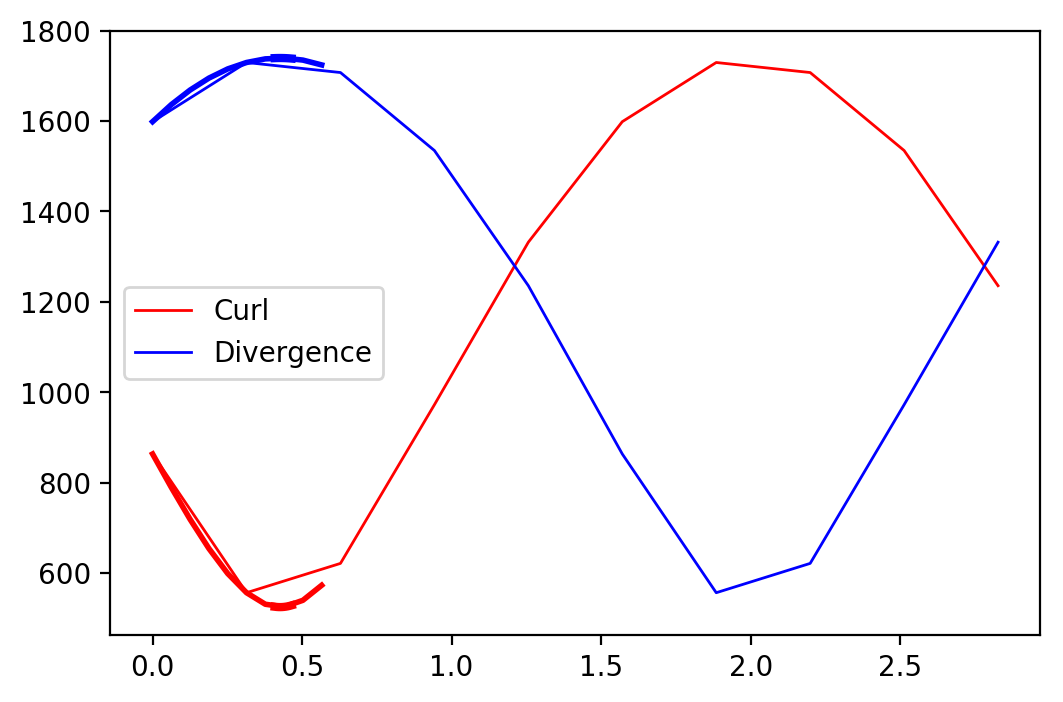

In [31]:
def FindAngleFromDPC(dat4d,DPCX,DPCY,order=3,plot=False):
    ### Find Rotation from PL Lenses by minimizing curl/maximizing divergence of DPC data
    ### Needed Inputs:   dat4d - 4D Dataset, 2-spatial, 2-diffraction dimensions
    ###                  DPCX,DPCY - As calculated DPC Shifts in X and Y directions
    ### Optional Inputs: order - Number of times to iterate the calculation to improve accuracy (recommend 3)
    ###                  plot - Set to True to see the charge and diverge plots as a check
    ### NOTE: This function has a 180 degree degeneracy, meaning that the minimum curl is achieved twice per
    ### 360 degrees, with no way to determine which is the correct rotation. This must be determined either by 
    ### Using defocus to physically see the correct orientation of the sample with respect to the scan coils,
    ### or by simply examining the data and determining which orientation presents physical results.
    
    def DPC_ACD(DPCX,DPCY,tlow,thigh):        
        A,C,D=[],[],[]
        for t in np.linspace(tlow,thigh,10,endpoint=False):            
            rDPCX,rDPCY=DPCX*np.cos(t)+DPCY*np.sin(t),-DPCX*np.sin(t)+DPCY*np.cos(t)        
            gXY,gXX=np.gradient(rDPCX);gYY,gYX=np.gradient(rDPCY)        
            C.append(np.std(gXY-gYX));D.append(np.std(gXX+gYY));A.append(t)
        G=np.average([A[np.argmin(C)],A[np.argmax(D)]])
        return G,A,C,D
    def plotCD(ax,g,a,c,d,N):
        ax.plot(a,c,color='r',lw=1+N,label='Curl')
        ax.plot(a,d,color='b',lw=1+N,label='Divergence')
        print('Pass '+str(N+1)+': Angle='+str(round(g*180./np.pi,1)))
        if N==0: ax.legend(fontsize=10)
    G=DPC_ACD(DPCX,DPCY,0,np.pi)
    if plot:
        f,a=plt.subplots(dpi=200)
        plotCD(a,*G,0)
    for i in range(1,order): 
        G=DPC_ACD(DPCX,DPCY,G[0]-np.pi/(10**i),G[0]+np.pi/(10**i))
        if plot: plotCD(a,*G,i)
    return G[0]
PLRotation=FindAngleFromDPC(dat4d,DPCX,DPCY,order=3,plot=True)

[]

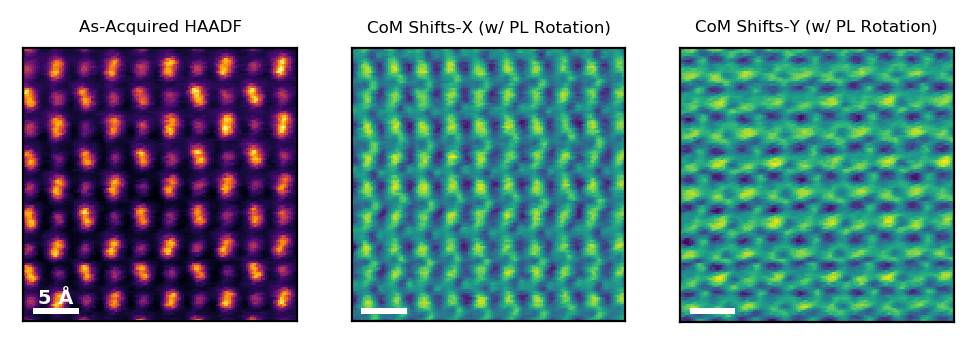

In [33]:
DPCX,DPCY=GetiCoM(dat4d,RonchiCenterX,RonchiCenterY,Ronchipixcal,PLRot=PLRotation)
f,a=plt.subplots(1,3,dpi=200)
a[0].imshow(datim,cmap=cm.inferno)
a[0].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[0].text(4+0.25/imcal,dat4d.shape[0]-7,'5 Å',fontweight='bold',color='w',fontsize=7,ha='center',va='bottom')
a[0].set_title('As-Acquired HAADF',fontsize=6)
a[1].imshow(DPCX)
a[1].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[1].set_title('CoM Shifts-X (w/ PL Rotation)',fontsize=6)
a[2].imshow(DPCY)
a[2].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[2].set_title('CoM Shifts-Y (w/ PL Rotation)',fontsize=6)
plt.setp(a, xticks=[],yticks=[])

[]

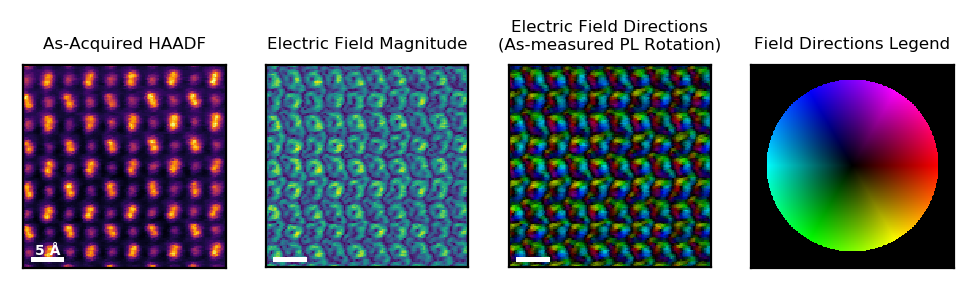

In [60]:
def GetElectricFields(DPCX,DPCY,Need180=False,LegPix=301,LegRad=0.85):
    ### Convert DPCX and DPCY maps to to a color map where the color corresponds to the angle
    ### Needed Inputs:   DPCX - X-Component of DPC Data (2D numpy array) 
    ###                  DPCY - Y-Component of DPC Data (2D numpy array)
    ###                  Need180 - Set to true, to Change PLRotation by 180
    ### Optional Inputs: LegPix - Number of Pixels in Color Wheel Legend 
    ###                  LegRad - Radius of Color Wheel in Legend (0-1)
    XY=np.zeros(DPCX.shape+(3,),dtype=float)
    EMag=np.sqrt(DPCX**2+DPCY**2)
    EMagScale=EMag/np.amax(EMag)
    if Need180: DPCX=-DPCX;DPCY=-DPCY
    for i in range(DPCX.shape[0]):
        for j in range(DPCY.shape[1]):
            XY[i,j]=(np.angle(np.complex(-DPCX[i,j],-DPCY[i,j])))/(2*np.pi)%1,1,EMagScale[i,j]
    EDir=hsv_to_rgb(XY)
    xx,yy=np.meshgrid(np.linspace(-1,1,LegPix,endpoint=True),np.linspace(-1,1,LegPix,endpoint=True))
    mxx,myy=xx*(xx**2+yy**2<LegRad**2),yy*(xx**2+yy**2<LegRad**2)
    I=np.sqrt(mxx**2+myy**2)
    XYLeg=np.zeros(mxx.shape+(3,),dtype=float)
    for i in range(mxx.shape[0]):
        for j in range(myy.shape[1]):
            XYLeg[i,j]=np.angle(np.complex(mxx[i,j],myy[i,j]))/(2*np.pi)%1,1,I[i,j]/np.amax(I)
    EDirLeg=hsv_to_rgb(XYLeg)
    return EMag,EDir,EDirLeg

EIm,EDirIm,EDirLeg=GetElectricFields(DPCX,DPCY,Need180=False)
f,a=plt.subplots(1,4,dpi=200)
a[0].imshow(datim,cmap=cm.inferno)
a[0].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[0].text(4+0.25/imcal,dat4d.shape[0]-7,'5 Å',fontweight='bold',color='w',fontsize=5,ha='center',va='bottom')
a[0].set_title('As-Acquired HAADF',fontsize=6)
a[1].imshow(EIm)
a[1].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[1].set_title('Electric Field Magnitude',fontsize=6)
a[2].imshow(EDirIm)
a[2].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[2].set_title('Electric Field Directions\n(As-measured PL Rotation)',fontsize=6)
a[3].imshow(EDirLeg)
a[3].set_title('Field Directions Legend',fontsize=6)
plt.setp(a, xticks=[],yticks=[])

[]

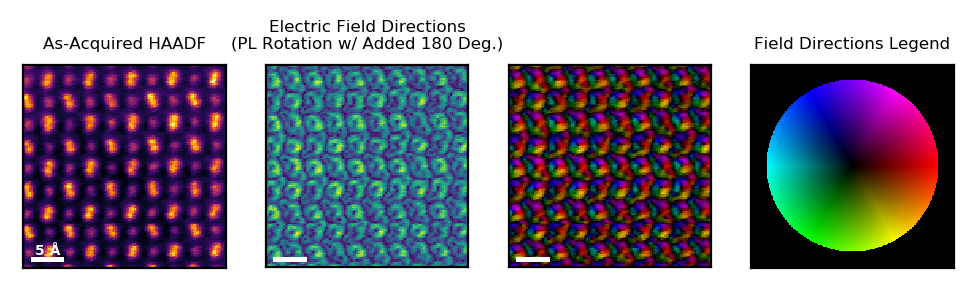

In [62]:
EIm,EDirIm,EDirLeg=GetElectricFields(DPCX,DPCY,Need180=True)
### NOTE: Without 180 Degree Rotation, E-Field points towards the Nuclei (i.e. goes from negative to positive).
### Since this is not physical, we know the 180 degree rotation is required for this dataset
f,a=plt.subplots(1,4,dpi=200)
a[0].imshow(datim,cmap=cm.inferno)
a[0].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[0].text(4+0.25/imcal,dat4d.shape[0]-7,'5 Å',fontweight='bold',color='w',fontsize=5,ha='center',va='bottom')
a[0].set_title('As-Acquired HAADF',fontsize=6)
a[1].imshow(EIm)
a[1].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[1].set_title('Electric Field Magnitude',fontsize=6)
a[2].imshow(EDirIm)
a[2].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[1].set_title('Electric Field Directions\n(PL Rotation w/ Added 180 Deg.)',fontsize=6)
a[3].imshow(EDirLeg)
a[3].set_title('Field Directions Legend',fontsize=6)
plt.setp(a, xticks=[],yticks=[])

[]

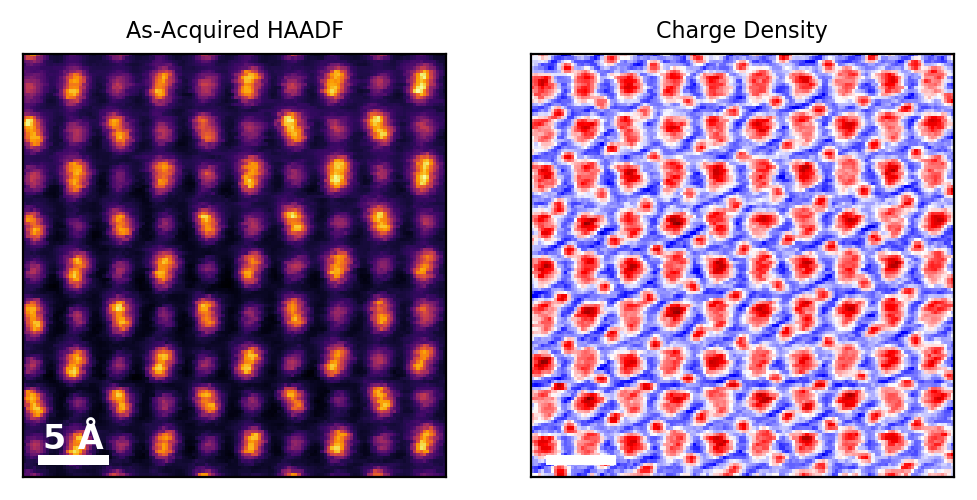

In [56]:
def GetChargeDensity(DPCX,DPCY,Need180=False):
    ### Calculate Charge Density from the Divergence of the Ronchigram Shifts
    ### Needed Inputs:   DPCX - X-Component of DPC Data (2D numpy array) 
    ###                  DPCY - Y-Component of DPC Data (2D numpy array)
    ###                  Need180 - Set to true, to Change PLRotation by 180
    if Need180: DPCX=-DPCX;DPCY=-DPCY
    gxx,gyy=np.gradient(DPCX)[1],np.gradient(DPCY)[0]
    return -gxx-gyy
RhoIm=GetChargeDensity(DPCX,DPCY,Need180=True)
f,a=plt.subplots(1,2,dpi=200)
a[0].imshow(datim,cmap=cm.inferno)
a[0].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[0].text(4+0.25/imcal,dat4d.shape[0]-7,'5 Å',fontweight='bold',color='w',fontsize=12,ha='center',va='bottom')
a[0].set_title('As-Acquired HAADF',fontsize=8)
a[1].imshow(RhoIm,cmap=cm.seismic,vmin=-np.amax(np.abs(RhoIm)),vmax=np.amax(np.abs(RhoIm)))
a[1].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[1].set_title('Charge Density',fontsize=8)
plt.setp(a, xticks=[],yticks=[])

[]

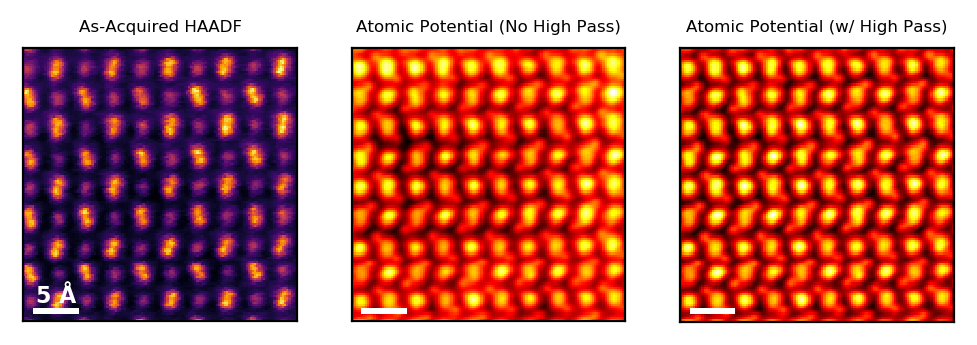

In [67]:
def GetPotential(DPCX,DPCY,Need180=False,hpass=0.,lpass=0.):
    ### Convert X and Y Shifts (E-Field Vector) Into Atomic Potential By Inverse Gradient
    ### Needed Inputs:   DPCX - X-Component of DPC Data (2D numpy array) 
    ###                  DPCY - Y-Component of DPC Data (2D numpy array)
    ###                  Need180 - Set to true, to Change PLRotation by 180
    ### Optional Inputs: hpass - Optional constant to provide variable high-pass filtering
    ###                  lpass - Optional constant to provide variable low-pass filtering
    ### Note: This method is vulnerable to edge induced artifacts that a small degree of high-pass filtering
    ### can clear up without significantly affectign the atomic-level contrast
    if Need180: DPCX=-DPCX;DPCY=-DPCY
    fCX=np.fft.fftshift(np.fft.fft2(np.fft.fftshift(DPCX)))
    fCY=np.fft.fftshift(np.fft.fft2(np.fft.fftshift(DPCY)))
    kx,ky=np.meshgrid(np.linspace(-1,1,fCX.shape[1],endpoint=True),np.linspace(-1,1,fCY.shape[0],endpoint=True))
    fCKX=fCX*kx;fCKY=fCY*ky
    fnum=(fCKX+fCKY)
    fdenom=np.pi*2*(0+1j)*(hpass+(kx**2+ky**2)+lpass*(kx**2+ky**2)**2)
    fK=np.divide(fnum,fdenom)
    return np.real(np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(fK))))

VIm=GetPotential(DPCX,DPCY,Need180=True)
VImhp=GetPotential(DPCX,DPCY,Need180=True,hpass=0.005)

f,a=plt.subplots(1,3,dpi=200)
a[0].imshow(datim,cmap=cm.inferno)
a[0].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[0].text(4+0.25/imcal,dat4d.shape[0]-7,'5 Å',fontweight='bold',color='w',fontsize=8,ha='center',va='bottom')
a[0].set_title('As-Acquired HAADF',fontsize=6)
a[1].imshow(VIm,cmap=cm.hot)
a[1].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[1].set_title('Atomic Potential (No High Pass)',fontsize=6)
a[2].imshow(VImhp,cmap=cm.hot)
a[2].add_patch(Rectangle((4,dat4d.shape[0]-7),0.5/imcal,3,fc='w',ec='None'))
a[2].set_title('Atomic Potential (w/ High Pass)',fontsize=6)
plt.setp(a, xticks=[],yticks=[])